# ***机器翻译***

# 0. 要解决的问题

① 你将建立一个神经机器翻译（NMT）模型，以将人类可读的日期（"25th of June, 2009"）转换为机器可读的日期（"2009-06-25"）。 

② 你将使用注意力模型来完成此任务，注意力模型是序列模型中最复杂的序列之一。

# 1. 导入库

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# 2. 日期转换

① 你在此处构建的模型可用于将一种语言翻译成另一种语言，例如从英语翻译成印地语。

② 但是，语言翻译需要大量的数据集，通常需要花费数天时间在GPU上进行训练。

③ 为了给你提供一个即使不使用大量数据集也可以试验这些模型的地方，我们将使用更简单的“日期转换”任务。

① 网络将以各种可能的格式输入日期（例如 "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"），并将其转换为标准化的机器可读日期（例如"1958-08-29", "1968-03-30", "1987-06-24"）。

② 我们将让网络学习如何以通用的机器可读格式YYYY-MM-DD输出日期。

③ 查看nmtutils.py以查看所有格式。计算并弄清楚格式如何工作，之后你将需要应用这些知识。

# 3. 数据集

① 我们将在10000个人类可读日期及其等效的标准化机器可读日期的数据集上训练模型。

② 让我们运行以下单元格以加载数据集并打印一些示例。

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 23872.18it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

③ 你已加载：

 - dataset ：（人可读日期，机器可读日期）元组列表
 - human_vocab：python字典，将人类可读日期中使用的所有字符映射到整数索引
 - machine_vocab：python字典，将机器可读日期中使用的所有字符映射到整数索引。这些索引不一定与human_vocab一致。
 - inv_machine_vocab：machine_vocab的逆字典，从索引映射回字符。

④ 让我们预处理数据并将原始文本数据映射到索引值。

⑤ 我们还将使用Tx = 30（我们假设这是人类可读日期的最大长度；如果输入的时间更长，则必须截断它）和Ty = 10（因为“YYYY-MM-DD”为10个长字符）。

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


① 你现在拥有：

 - X：训练集中人类可读日期的处理版本，其中每个字符都由通过human_vocab映射到该字符的索引替换。每个日期都用特殊字符（<pad>）进一步填充为
值。X.shape = (m, Tx)
 - Y：训练集中机器可读日期的处理版本，其中每个字符都被映射为machine_vocab中映射到的索引替换。你应该具有Y.shape = (m, Ty)。
 - Xoh：X的一个独热版本，由于human_vocab，将“1”条目的索引映射到该字符。Xoh.shape = (m, Tx, len(human_vocab))
 - Yoh：Y的一个独热版本，由于使用machine_vocab，因此将“1”条目的索引映射到了该字符。Yoh.shape = (m, Tx, len(machine_vocab))在这里，因为有11个字符（“-”以及0-9），所以len(machine_vocab) = 11。
    
② 我们再看一些预处理训练集的示例。你可以在下面的单元格中随意使用index来查看数据集，并查看如何对source/target日期进行预处理。

In [5]:
print(Xoh)

[[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]]


In [6]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# 4. 注意力机制

① 如果你必须将一本书的段落从法语翻译为英语，则无需阅读整个段落然后关闭该书并进行翻译。

② 即使在翻译过程中，你也会阅读/重新阅读并专注于与你所写下的英语部分相对应的法语段落部分。

③ 注意机制告诉神经机器翻译模型在任何步骤都应该注意到的地方。

① 在这一部分中，你将实现讲座视频中介绍的注意力机制。

② 这是一个提醒你该模型如何工作的图。

③ 左图显示了注意力模型。右图显示了“注意”步骤用于计算注意变量$\alpha^{\langle t, t' \rangle}$，这些变量用于计算上下文变量$context^{\langle t \rangle}$输出中的每个时间步长($t=1, \ldots, T_y$)。

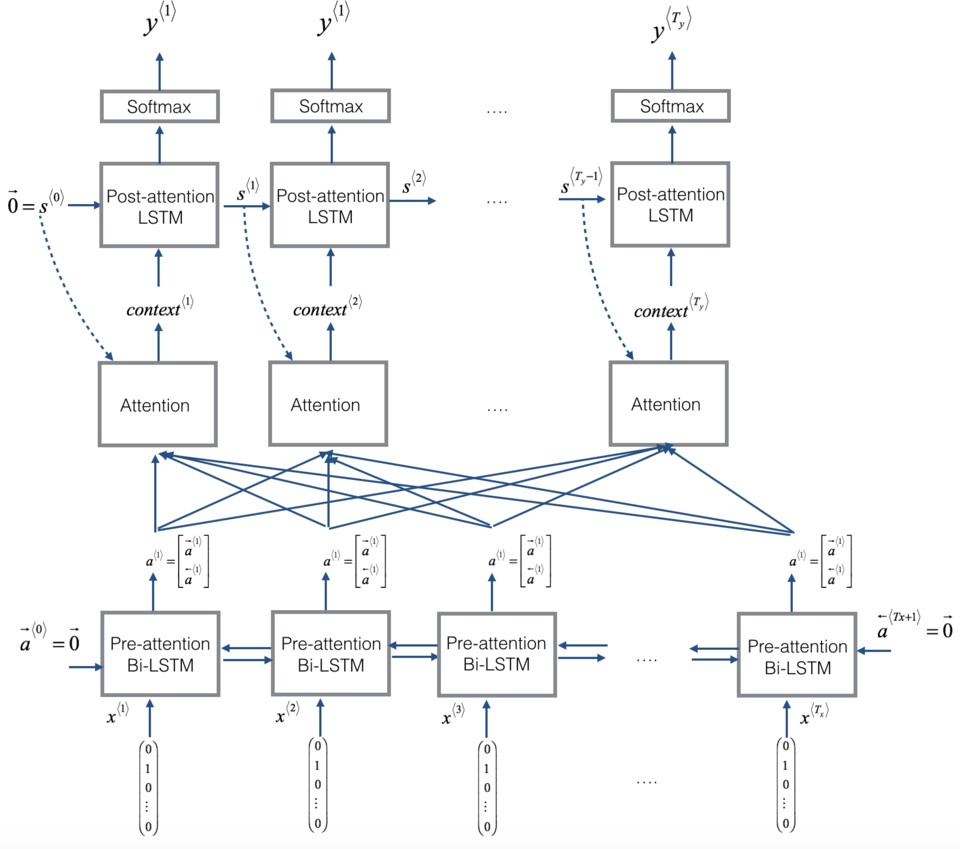

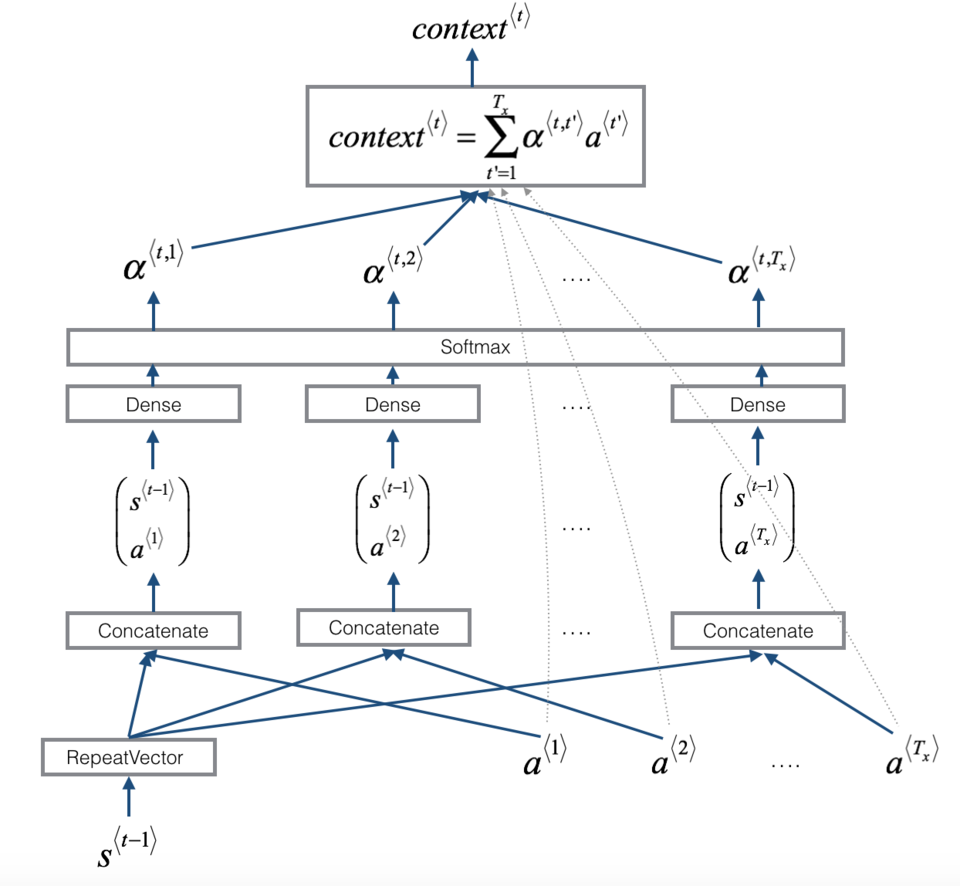

<center>图1：带注意力机制的神经机器翻译</center>

④ 你可能会注意到以下一些模型属性：

 - 此模型中有两个单独的LSTM（请参见左侧的图）。
   - 因为图片底部的一个是双向LSTM，并且在“注意力机制”之前出现，所以我们将其称为pre-attention Bi-LSTM。
   - 图表顶部的LSTM在注意力机制之后，因此我们将其称为post-attention LSTM。
   - pre-attention Bi-LSTM经过$T_x$个时间步长；post-attention LSTM经过$T_y$个时间步长。

 - post-attention LSTM 从一个时间步长传递到下一个步长，传递$s^{\langle t \rangle}, c^{\langle t \rangle}$。
   - 在讲座视频中，我们仅将基本RNN用于激活后序列模型，因此RNN输出激活捕获的状态$s^{\langle t\rangle}$。
   - 但是，由于我们在这里使用LSTM，因此LSTM既具有输出激活$s^{\langle t\rangle}$，也具有隐藏单元状态$c^{\langle t\rangle}$。
   - 但是，与先前的文本生成示例（例如第1周的恐龙）不同，在此模型中，时间$t$的激活后LSTM不会将特定的生成的$y^{\langle t-1 \rangle}$作为输入只需将$s^{\langle t\rangle}$和$c^{\langle t\rangle}$作为输入。
   - 我们以这种方式设计了模型，因为（与相邻字符高度相关的语言生成不同），在YYYY-MM-DD日期中，上一个字符与下一个字符之间没有那么强的依赖性。

 - 我们使用$a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$表示pre-attention Bi-LSTM的正向和反向激活的串联。

 - 右图使用RepeatVector节点复制$s^{\langle t-1 \rangle}$的值$T_x$次，然后使用Concatenation来连接$s^{\langle t-1 \rangle}$和$a^{\langle t \rangle}$来计算$e^{\langle t, t'}$，然后将其传递给softmax以计算$\alpha^{\langle t, t' \rangle}$。
   - 我们将在下面的Keras中说明如何使用RepeatVector和Concatenation。

① 让我们实现这个模型。你将从实现one_step_attention() 和 model()两个函数开始：

1）one_step_attention()：在步骤$t$中，给出Bi-LSTM的所有隐藏状态$([a^{<1>},a^{<2>}, ..., a^{<Tx>}])$和第二个的先前隐藏状态$s^{<t-1>}$)，one_step_attention()将计算注意力权重$([\alpha^{t,1},\alpha^{t,2}, ..., \alpha^{t,Tx}])$并输出上下文向量：$$context^{} = \sum_{t' = 0}^{T_x} \alpha^{t,t'}a^{t'}\tag{1}$$

 - 请注意，我们在此笔记本中将注意力表示为$context^{\langle t \rangle}$。在讲座视频中，上下文被表示为$c^{\langle t \rangle}$，但在这里我们将其称为$context^{\langle t \rangle}$，以避免与(post-attention)LSTM内部记忆单元变量混淆，有时也称为$c^{\langle t \rangle}$。
 
2）model()：实现整个模型。它首先通过Bi-LSTM运行输入以获取$[a^{<1>},a^{<2>}, ..., a^{<Tx>}]$。然后，它调用one_step_attention()$T_y$次（“for”循环）。在此循环的每次迭代中，它将计算出上下文向量$c^{<t>}$给第二个 LSTM, 根据 LSTM 的输出，运行 softmax 激活的全连接层以生成预测$\hat{y}^{<t>}$。

② 练习：实现one_step_attention()。函数 model()将使用for循环调用one_step_attention()$T_y$中的层，重要的是所有$T_y$副本具有相同的权重。即，它不应该每次都重新初始化权重。换句话说，所有$T_y$步骤均应具有权重。这是在Keras中实现可共享权重的层的方法：

1. 定义层对象（例如，作为全局变量）。
2. 在传播输入时调用这些对象。

In [7]:
# 将共享层定义为全局变量 
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # 在这个 notebook 我们正在使用自定义的 softmax(axis = 1)
dotor = Dot(axes = 1)

③ 现在你可以使用这些层来实现one_step_attention()。 为了通过这些层之一传播Keras张量对象X，请使用layer（X）（如果需要多个输入则使用layer（[X，Y]））。densor(X)将通过上面定义的 Dense(1) 层传播X。

In [8]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    执行一步 attention: 输出一个上下文向量，输出作为注意力权重的点积计算的上下文向量
    "alphas"  Bi-LSTM的 隐藏状态 "a"
    
    参数：
    a --  Bi-LSTM的输出隐藏状态 numpy-array 维度 (m, Tx, 2*n_a)
    s_prev -- (post-attention) LSTM的前一个隐藏状态, numpy-array 维度(m, n_s)
    
    返回：
    context -- 上下文向量, 下一个(post-attetion) LSTM 单元的输入
    """
    
    # 使用 repeator 重复 s_prev 维度 (m, Tx, n_s) 这样你就可以将它与所有隐藏状态"a" 连接起来。 (≈ 1 line)
    s_prev = repeator(s_prev)
    # 使用 concatenator 在最后一个轴上连接 a 和 s_prev (≈ 1 line)
    concat = concatenator([a, s_prev])
    # 使用 densor1 传入参数 concat, 通过一个小的全连接神经网络来计算“中间能量”变量 e。(≈1 lines)
    e = densor1(concat)
    # 使用 densor2 传入参数 e , 通过一个小的全连接神经网络来计算“能量”变量 energies。(≈1 lines)
    energies = densor2(e)
    # 使用 activator 传入参数 "energies" 计算注意力权重 "alphas" (≈ 1 line)
    alphas = activator(energies)
    # 使用 dotor 传入参数 "alphas" 和 "a" 计算下一个（(post-attention) LSTM 单元的上下文向量 (≈ 1 line)
    context = dotor([alphas, a])
    
    return context

① 在对model()函数进行编码之后，你将能够检查one_step_attention()的预期输出。

② 练习：按照图2和上面的文字中的说明实现model()。同样，我们定义了全局层，这些全局层将共享将在model()中使用的权重。

In [9]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

③ 现在你可以在for循环中使用这些层$T_y$次来生成输出，并且它们的参数将不会重新初始化。你将必须执行以下步骤：

 1. 将输入传播到Bidirectional LSTM
 2. 迭代$t = 0, \dots, T_y-1$：
    - 在$[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,Tx>}]和s^{<t-1>}$上调用 one_step_attention() 以获取上下文向量$context^{<t>}$。
    - 将$context^{<t>}$分配给post-attention LSTM单元。请记住，使用initial_state= [previous hidden state, previous cell state]传递此LSTM的前一个隐藏状态$s^{<t-1>}$和单元状态$c^{<t-1>}$。取回新的隐藏状态$s^{<t>}和新的单元状态c^{<t>}$。
    - 将softmax层应用于$s^{<t>}$，获得输出。
    - 通过将输出添加到输出列表中来保存输出。
 3. 创建你的Keras模型实例，它应该具有三个输入("inputs",$s^{<0>}$and$c^{<0>}$)并输出"outputs"列表。

In [10]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    参数:
    Tx -- 输入序列的长度
    Ty -- 输出序列的长度
    n_a -- Bi-LSTM的隐藏状态大小
    n_s -- post-attention LSTM的隐藏状态大小
    human_vocab_size -- python字典 "human_vocab" 的大小
    machine_vocab_size -- python字典 "machine_vocab" 的大小

    返回：
    model -- Keras 模型实例
    """
    
    # 定义模型的输入，维度 (Tx,)
    # 定义 s0 和 c0, 初始化解码器 LSTM 的隐藏状态，维度 (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # 初始化一个空的输出列表
    outputs = []
    
    
    # 第一步：定义 pre-attention Bi-LSTM。 记得使用 return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True), input_shape=(m, Tx, n_a * 2))(X)
    
    # 第二步：迭代 Ty 步
    for t in range(Ty):
    
        # 第二步.A: 执行一步注意机制，得到在 t 步的上下文向量 (≈ 1 line)
        context = one_step_attention(a, s)
        
        # 第二步.B: 使用 post-attention LSTM 单元得到新的 "context" 
        # 别忘了使用： initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # 第二步.C: 使用全连接层处理post-attention LSTM 的隐藏状态输出 (≈ 1 line)
        out = output_layer(s)
        
        # 第二步.D: 追加 "out" 到 "outputs" 列表 (≈ 1 line)
        outputs.append(out)
    
    # 第三步：创建模型实例，获取三个输入并返回输出列表。 (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
        
    return model

In [11]:
# 运行以下单元以创建模型
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [12]:
# 让我们查看模型的摘要，以检查它是否与预期输出相匹配
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

① 与往常一样，在Keras中创建模型后，你需要对其进行编译并定义要使用的损失，优化器和评价指标。 使用categorical_crossentropy损失，自定义Adam optimizer(learning rate = 0.005,$\beta_1 = 0.9$,$\beta_2 = 0.999$, decay = 0.01)和['accuracy']指标：

In [13]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END CODE HERE ###

② 最后一步是定义所有输入和输出以适合模型：

 - 你已经拥有包含训练示例的维度为$(m = 10000, T_x = 30)$的X。
 - 你需要创建s0和c0以将你的post_activation_LSTM_cell初始化为0。
 - 根据你编码的model()，你需要"outputs"作为11个维度元素（m，T_y）的列表。因此：outputs[i][0], ..., outputs[i][Ty]代表与$i^{th}$训练示例(X[i])。更一般而言， outputs[i][j] 是$i^{th}$训练示例中$j^{th}$字符的真实标签。

In [14]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [15]:
# 现在让我们拟合模型并运行一个epoch
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 11s 1ms/step - loss: 16.4762 - dense_3_loss: 2.5963 - dense_3_acc: 0.6048 - dense_3_acc_1: 0.7668 - dense_3_acc_2: 0.3051 - dense_3_acc_3: 0.0867 - dense_3_acc_4: 0.9179 - dense_3_acc_5: 0.3329 - dense_3_acc_6: 0.0502 - dense_3_acc_7: 0.8896 - dense_3_acc_8: 0.2415 - dense_3_acc_9: 0.0925


① 训练时，你可以看到输出的10个位置中的每个位置的损失以及准确性。下表为你提供了一个示例，说明该批次有2个示例时的精确度：

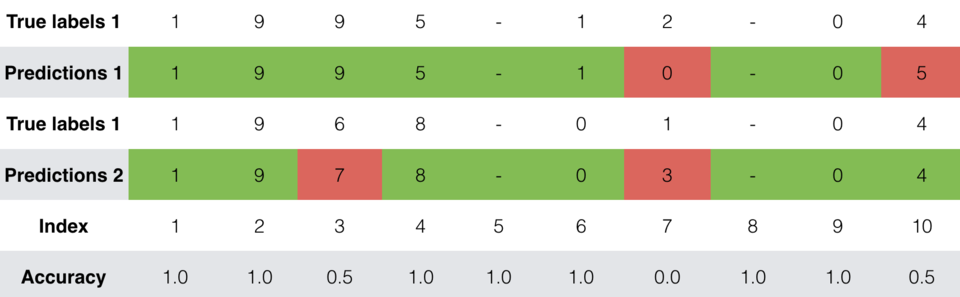

② 因此，dense_2_acc_8: 0.89意味着你在当前数据批次中有89％的时间正确预测了输出的第7个字符。

③ 我们对该模型运行了更长的时间，并保存了权重。运行下一个单元格以加载我们的权重。（通过训练模型几分钟，你应该可以获得准确度相似的模型，但是加载我们的模型可以节省你的时间。）

In [16]:
model.load_weights('datasets/model.h5')

④ 现在，你可以在新示例中查看结果。

In [17]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


⑤ 你也可以更改这些示例，以使用自己的示例进行测试。

⑥ 下一部分将使你更好地了解注意力机制的作用-即生成特定输出字符时网络要注意的输入部分。

# 5. 可视化注意力

① 由于问题的输出长度固定为10，因此还可以使用10个不同的softmax单元来执行此任务，以生成10个字符的输出。但是注意力模型的一个优点是输出的每个部分（例如月份）都知道它只需要依赖输入的一小部分（输入中代表月份的字符）。

② 我们可以可视化输出的哪一部分正在查看输入的哪一部分。

③ 考虑将"Saturday 9 May 2018"转换为"2018-05-09"的任务。如果我们可视化计算出的$\alpha^{\langle t, t' \rangle}$，我们将得到：

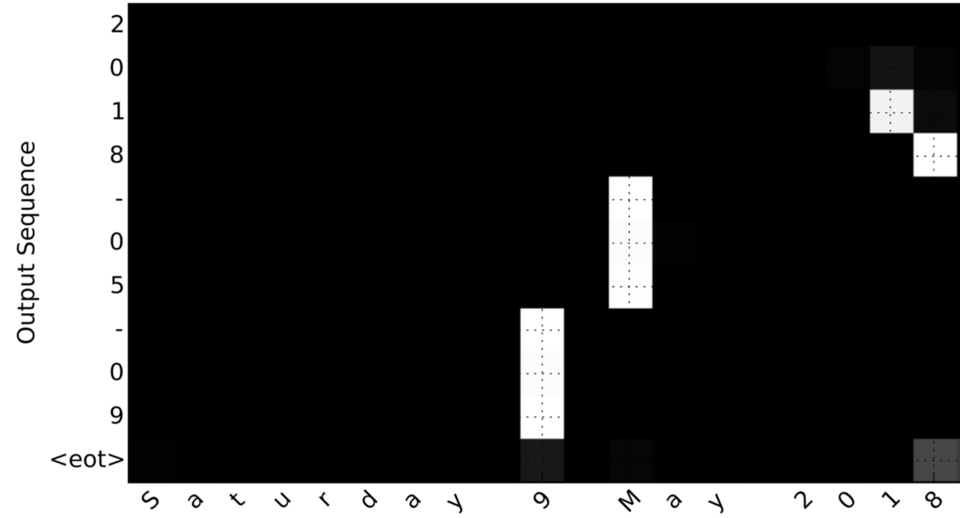

<center>图8：Full Attention Map</center>

④ 注意输出如何忽略输入的"Saturday"部分。没有一个输出时间步长关注输入的那部分。我们还看到9已被翻译为09，May已被正确翻译为05，而输出则注意进行翻译所需的部分输入。该年份主要要求它注意输入的“18”以生成“2018”。

① 现在让我们可视化你网络中的注意力值。我们将通过网络传播一个示例，然后可视化$\alpha^{<t,t'>}$的值。

② 为了弄清注意值的位置，让我们开始打印模型摘要。

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

③ 浏览上面的model.summary()的输出。你可以看到，在每个时间步dot_2计算$t = 0, \ldots, T_y-1$上下文向量之前，名为attention_weights的层都会输出维度为(m, 30, 1)的alphas。让我们从该层获取激活。

④ 函数attention_map()从模型中提取注意力值并绘制它们。

<Figure size 432x288 with 0 Axes>

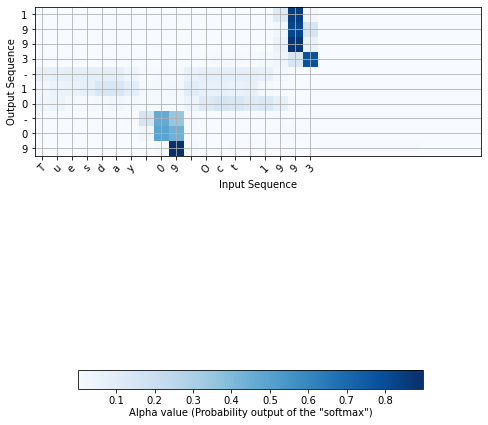

In [19]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

⑤ 在生成的图上，你可以观察预测输出的每个字符的注意权重值。检查此图，并检查网络对你的关注是否有意义。

⑥ 在日期转换应用程序中，你会发现大部分时间的注意力都有助于预测年份，并且对预测日期/月份没有太大影响。

① 恭喜！你已结束本作业

② 这是你在此笔记本中应记住的内容：

 - 机器翻译模型可用于从一个序列映射到另一个序列。它们不仅对翻译人类语言（如法语->英语）有用，而且对日期格式翻译等任务也很有用。
 - 注意机制允许网络在产生输出的特定部分时将注意力集中在输入的最相关部分。
 - 使用注意力机制的网络可以将长度为$T_x$的输入转换为长度为$T_y$的输出，其中$T_x$和$T_y$可以不同。
 - 你可以可视化注意权重$\alpha^{\langle t,t' \rangle}$，以查看网络在生成每个输出时要注意的内容。

③ 恭喜你完成此作业！ 现在，你可以实现注意力模型，并使用它来学习从一个序列到另一个序列的复杂映射。